In [ ]:
import numpy
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import random
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.stats import pearsonr
from typing import Dict, Tuple
from tqdm import tqdm
from collections import defaultdict
import polars as pl
import json
from scipy import stats
import multiprocessing

import sys 
sys.path.append('/home/nas2/biod/zhencaiwei/MultiChat-main/MultiChat/')
from Model import utilities, model_training
from Data_preprocessing import Processing, Intra_strength

# Processing

In [ ]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/'
db = pd.read_csv(os.path.join(base_path, "inputs/LRpairDB.csv"), header=0, sep="\t")
db = db.drop_duplicates()
cell_rep = pd.read_csv(os.path.join(base_path, "inputs/RNA_data_norm.csv"), header=0, index_col=0, sep=",")
cell_rep = cell_rep.T
expmatrix = pd.read_csv(os.path.join(base_path, "inputs/RNA_data_norm.csv"), header=0, index_col=0, sep=",")
non_zero_counts = (expmatrix > 0).sum(axis=1)
expmatrix_filt1 = expmatrix[non_zero_counts >= 5]
split_ligand_symbols = db['Ligand_Symbol'].str.split('_') 
mask_ligand = split_ligand_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db[mask_ligand] 
split_receptor_symbols = db_filt1['Receptor_Symbol'].str.split('_') 
mask_receptor = split_receptor_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db_filt1[mask_receptor] 
lig_exp, rec_exp = Processing.Preprocess_CCC_model(base_path, db_filt1, cell_rep, expmatrix_filt1)

# run InterCCC

In [3]:
'''get postive pairs'''
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.txt', header=0, index_col=0, sep="\t")
cell_clus.rename(columns={'celltype': 'cell_type'}, inplace=True)
cell_loc = pd.read_csv(base_path+'inputs/Coord.txt', header=0, index_col=0, sep="\t")
parser  =  utilities.parameter_setting()
args, unknown = parser.parse_known_args()
args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/'
args.outPath            = args.inputPath + 'CCC/'
utilities.get_cell_positive_pairs(cell_clus, cell_loc, args)

In [ ]:
'''InterCCC model training'''
parser  =  utilities.parameter_setting() 
args, unknown = parser.parse_known_args()

args.gpu_id = 1
if args.use_cuda and torch.cuda.is_available():
    device = torch.device(f'cuda:{args.gpu_id}')
    torch.cuda.set_device(args.gpu_id)
else:
    device = torch.device('cpu')
    
## random seed 
numpy.random.seed( args.seed )
random.seed( args.seed )
torch.manual_seed( args.seed )
torch.cuda.manual_seed( args.seed )

start = time.time()
args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/'
args.use_cuda           = args.use_cuda and torch.cuda.is_available()

args.outPath            = args.inputPath + 'CCC/'	
args.spatialLocation    = args.inputPath + 'inputs/' + 'Coord.csv'
args.annoFile           = args.inputPath + 'inputs/' + 'celltype_info.txt'
args.pos_pair           = args.outPath + args.pos_pair

args.Ligands_exp        = args.outPath + args.Ligands_exp
args.Receptors_exp      = args.outPath + args.Receptors_exp

args.patience           = 15
args.lr_cci             = 0.001
args.attn_drop          = 0
args.tau                = 0.05

args.selected_cell_type = None
args.InterCCC_Name      = 'LRI_module_strength.txt'

model_training.Train_CCC_model(args)
# select_cell_type = 'B cell'
# model_training.Train_CCC_model_sel_ct(args)
	
duration = time.time() - start
print('Finish training, total time is: ' + str(duration) + 's' )

spot location for adjancy
spot-ligand data
spot-receptor data
Size of CCC pairs: 50
Start model training
0 cost: tensor(220.6443)
10 cost: tensor(184.0219) tensor(0.0236, device='cuda:1', grad_fn=<DivBackward0>)
20 cost: tensor(128.6185) tensor(0.0456, device='cuda:1', grad_fn=<DivBackward0>)
30 cost: tensor(73.7992) tensor(0.0596, device='cuda:1', grad_fn=<DivBackward0>)
40 cost: tensor(39.2769) tensor(0.0582, device='cuda:1', grad_fn=<DivBackward0>)
50 cost: tensor(22.5036) tensor(0.0519, device='cuda:1', grad_fn=<DivBackward0>)
60 cost: tensor(13.5355) tensor(0.0478, device='cuda:1', grad_fn=<DivBackward0>)
70 cost: tensor(8.5289) tensor(0.0427, device='cuda:1', grad_fn=<DivBackward0>)
80 cost: tensor(5.7456) tensor(0.0349, device='cuda:1', grad_fn=<DivBackward0>)
90 cost: tensor(4.2403) tensor(0.0263, device='cuda:1', grad_fn=<DivBackward0>)
100 cost: tensor(3.3576) tensor(0.0208, device='cuda:1', grad_fn=<DivBackward0>)
110 cost: tensor(2.7791) tensor(0.0172, device='cuda:1', grad

## Generate Background InterCCC data

In [ ]:
'''Step1:get background postive pairs'''
pos_pair = pd.read_csv(base_path + 'CCC/Spot_positive_pairs.txt', header=None, index_col=None, sep="\t")
pos_pair_perturb = pos_pair.apply(utilities.perturb_pos_pair_row, axis=1)
lig_exp = pd.read_csv(base_path + 'CCC/ligands_expression.txt', header=0, index_col=0, sep="\t")
rec_exp = pd.read_csv(base_path + 'CCC/receptors_expression.txt', header=0, index_col=0, sep="\t")
lig_exp_shuffled = lig_exp.apply(np.random.permutation)
rec_exp_shuffled = rec_exp.apply(np.random.permutation)
lig_exp_shuffled.to_csv(base_path + 'Bg_CCC/ligands_expression_shuffled.txt', sep="\t")
rec_exp_shuffled.to_csv(base_path + 'Bg_CCC/receptors_expression_shuffled.txt', sep="\t")
pos_pair_perturb.to_csv(base_path + 'Bg_CCC/Spot_positive_pairs_shuffled.txt', sep="\t", header=False, index=False)

In [ ]:
'''Step2-1:Run MultiChat_Inter to generate 10 sets of background data in parallel'''
def run_training(run_idx):  
    parser = utilities.parameter_setting()
    args, unknown = parser.parse_known_args()
    args.gpu_id = 0
    
    base_seed = 42  
    args.seed = base_seed + run_idx
    
    if args.use_cuda and torch.cuda.is_available():
        device = torch.device(f'cuda:{args.gpu_id}')
        torch.cuda.set_device(device)  
    else:
        device = torch.device('cpu')
    
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    start = time.time()
    start = time.time()
    args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/'
    args.use_cuda           = args.use_cuda and torch.cuda.is_available()

    args.outPath            = args.inputPath + 'Bg_CCC/'	
    args.spatialLocation    = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/inputs/Coord.csv'
    args.annoFile           = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/inputs/celltype_info.txt'
    args.pos_pair           = args.outPath + 'Spot_positive_pairs_shuffled.txt'
    args.Ligands_exp        = args.outPath + 'ligands_expression_shuffled.txt'
    args.Receptors_exp      = args.outPath + 'receptors_expression_shuffled.txt'
    
    args.patience = 15
    args.lr_cci = 0.001
    args.attn_drop = 0
    args.tau = 0.05
    
    args.lrp_strength_file = args.outPath + f'LRI_module_strength_run_{run_idx}.txt'
    
    # Run training
    model_training.Train_CCC_model_parallel(args)
    
    duration = time.time() - start
    print(f'Finish training run {run_idx}, total time: {duration}s')

In [ ]:
'''Step2-2:Run MultiChat_Inter to generate 10 sets of background data in parallel'''
if __name__ == '__main__':
    # multiprocessing.set_start_method('spawn', force=True)
    run_indices = list(range(1, 11))  # [1, 2, 3, ..., 10]
    
    with multiprocessing.Pool(processes=5) as pool:
        pool.map(run_training, run_indices)

spot location for adjancyspot location for adjancy

spot location for adjancy
spot location for adjancy
spot location for adjancy
spot-ligand data
spot-ligand dataspot-receptor data

spot-ligand data
spot-ligand dataspot-ligand data

spot-receptor data
spot-receptor data
spot-receptor dataspot-receptor data

Size of CCC pairs: 50
Size of CCC pairs: 50Size of CCC pairs: 50

Size of CCC pairs: 50Size of CCC pairs: 50

Start model trainingStart model trainingStart model training


Start model trainingStart model training

Using GPU: 0
Using GPU: 0Using GPU: 0Using GPU: 0Using GPU: 0



0 cost: 1045.0729980468750 cost: 1060.35656738281250 cost: 1050.455566406250 cost: 1114.98425292968750 cost: 1123.6566162109375




10 cost: 733.7869873046875 0.03612628579139709510 cost: 767.7011108398438 0.0397279448807239510 cost: 780.3530883789062 0.0387640632688999210 cost: 723.056640625 0.03644138947129249610 cost: 755.1025390625 0.035082124173641205




20 cost: 549.96044921875 0.01961519941687584
20

# Identify Significant L->R pair

## Identify singl-cell level significant L->R pair

In [4]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/'
background_inter_df = Intra_strength.load_background_inter(base_path+'Bg_CCC/', file_pattern="LRI_module_strength_run_*.txt")
background_inter_df.to_csv(base_path + 'Bg_CCC/LRI_module_strength_concat.txt', sep="\t", index=True)
sample_inter_df = pd.read_csv(base_path+'CCC/LRI_module_strength.txt', sep='\t', index_col=0)
lr_lst = sample_inter_df.columns.tolist()
sub_background_inter_df = background_inter_df.loc[:, lr_lst]

In [5]:
sig_LR_pair = Intra_strength.Identify_significant_lr_pairs(
    background_inter_df=sub_background_inter_df,
    sample_inter_df=sample_inter_df,
    output_path=base_path+'CCC/Significant_LRs.csv',
    z_critical=None,
    alpha=0.5
)
sig_LR_pair.head()

Processing samples: 600it [00:00, 800.23it/s]


Significant_L->R pairs saved to /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/Significant_LRs.csv


,Sample_Name,LR_Symbol,Inter_Score,Z_Score
0,cell1,gene339->gene153,0.034685,4.464500
1,cell1,gene351->gene134,0.025305,4.196563
2,cell1,gene355->gene131,0.026175,2.094655
3,cell1,gene348->gene141,0.030273,1.885070
4,cell1,gene351->gene121,0.010490,1.855079


## Identify cell-type level significant L->R pair

In [6]:
background_inter_df = Intra_strength.load_background_inter(base_path+'Bg_CCC/', file_pattern="LRI_module_strength_run_*.txt")
sample_inter_df = pd.read_csv(base_path+'CCC/LRI_module_strength.txt', sep='\t', index_col=0)  
cell_clus = pd.read_csv(base_path+'/inputs/celltype_info.txt', header=0, index_col=0, sep="\t")
sig_LR_pair = pd.read_csv(base_path+'CCC/Significant_LRs.csv', header=0, sep=",")
sig_LR_pair_celltype = Intra_strength.Identify_significant_lr_pairs_celltype(sig_LR_pair, cell_clus, agg_method='mean')
merged = sample_inter_df.join(cell_clus)  
sample_inter_ct_df = merged.groupby('celltype').mean()
sample_inter_ct_df.index.name = None 
vola_LR_pair_celltype, vola_LR_pair_celltype_vscore,vola_LR_pair_celltype_bin,_ = Intra_strength.Identify_volatile_lr_pairs_celltype(sample_inter_ct_df, threshold=2.5, method='mad')
outs_path = base_path+'CCC/Significant_LRs_ct_concat.csv' 
sig_LR_pair_celltype_concat = Intra_strength.Identify_concat_lr_pairs_celltype(sig_LR_pair_celltype,vola_LR_pair_celltype,outs_path)

sig_LR_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/Significant_LRs_ct_concat.csv


# run IntraCCC

## Load data

In [7]:
rna_mat = pd.read_csv(base_path + 'CCC/expression_smooth.txt', header=0, index_col=0, sep="\t")
atac_mat = pd.read_csv(base_path + 'inputs/ATAC_data_norm.csv', header=0, index_col=0, sep=",")
tg_re_df = pd.read_csv(base_path + 'inputs/peak_gene_df.csv', sep=",")
gene_rep = pd.read_csv(base_path + 'HGEmb/Gene_rep.csv', index_col=0)
cell_rep = pd.read_csv(base_path + 'HGEmb/Cell_rep.csv', index_col=0)
sample_order = rna_mat.columns.tolist()
cell_rep_aligned = cell_rep.loc[sample_order]
tf_rep = pd.read_csv(base_path + 'HGEmb/TF_rep.csv', index_col=0)
lst = tf_rep.index.tolist()
new_lst = [item.replace('M_', '', 1) for item in lst]
tf_rep.index = new_lst
peak_rep = pd.read_csv(base_path + 'HGEmb/Peak_rep.csv', index_col=0)
tf_re_ba = pd.read_csv(base_path + 'inputs/peak_tf_mtx.txt', index_col=0, sep="\t")
l_r_df = pd.read_csv(base_path + 'inputs/LRpairDB.csv', sep="\t") 
L_R_TF_TG_df = pd.read_csv(base_path + 'inputs/Ligand_Receptor_TF_TG_pairs.csv', sep='\t')

In [8]:
unique_counts = L_R_TF_TG_df.nunique()
unique_counts

Ligand_Symbol      46
Receptor_Symbol    44
TF_Symbol           6
TG_Symbol          45
dtype: int64

## Get TF-TG Strength

In [9]:
rna_mat_minmax = (rna_mat - rna_mat.min()) / (rna_mat.max() - rna_mat.min()) # column-wise normalization
atac_mat_minmax = atac_mat.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) # row-wise normalization
atac_mat_minmax = atac_mat_minmax.T

In [10]:
rna_mat_minmax

,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,cell10,...,cell591,cell592,cell593,cell594,cell595,cell596,cell597,cell598,cell599,cell600
gene1,0.952270,0.994352,0.313451,0.671425,1.0,0.667996,0.963238,0.000000,0.632483,1.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene396,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.342617,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene397,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
gene398,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.393449,0.0,0.000000,0.000000,0.0,0.0
gene399,0.000000,0.000000,0.350011,0.000000,0.0,0.000000,0.000000,0.362169,0.352140,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
atac_mat_minmax

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,peak8,peak9,peak10,...,peak1191,peak1192,peak1193,peak1194,peak1195,peak1196,peak1197,peak1198,peak1199,peak1200
cell1,0.816606,0.627592,0.491211,0.000000,0.000000,0.464011,0.087732,0.563403,0.307669,0.879595,...,0.749059,0.000000,0.000000,0.824920,0.000000,0.000000,0.927837,0.669556,0.668042,0.652071
cell2,0.484491,0.000000,0.000000,0.690250,0.898032,0.278909,0.556646,0.150149,0.177449,0.463539,...,0.000000,0.000000,0.692365,0.000000,1.000000,0.000000,0.406017,0.738279,0.000000,0.727787
cell3,0.000000,0.535311,0.000000,0.881297,0.000000,0.679222,0.412847,0.000000,0.925523,0.000000,...,0.909449,0.188945,0.000000,0.495358,0.822774,0.751691,0.000000,0.687411,0.000000,0.743889
cell4,0.216734,0.000000,0.000000,0.754980,0.605433,0.784780,0.000000,0.643165,0.000000,1.000000,...,0.835395,0.000000,0.000000,0.635756,0.852242,0.000000,0.711903,0.000000,0.526560,0.000000
cell5,0.614821,0.038726,0.731920,0.611322,0.000000,0.741659,0.000000,0.510825,0.749067,0.425996,...,0.753421,0.492573,0.619763,0.852441,0.443863,0.611915,0.785948,0.500270,0.404177,0.558651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell596,0.424175,0.000000,0.000000,0.499876,0.000000,0.487527,0.000000,0.771748,0.805582,0.000000,...,0.713632,0.000000,0.000000,0.978637,0.000000,0.653040,0.000000,0.792515,0.825346,0.000000
cell597,0.653081,0.000000,0.000000,0.000000,0.697488,0.335114,0.432849,0.798560,0.000000,0.000000,...,0.603353,0.853213,0.756651,0.696769,0.096135,0.302631,0.573416,0.200781,0.782540,0.600387
cell598,0.000000,0.511094,0.961357,0.000000,0.549992,0.000000,0.667733,0.387385,0.337485,0.833143,...,0.856490,0.661794,0.799354,0.944538,0.785032,0.000000,0.000000,0.605716,1.000000,0.857645
cell599,0.485152,0.010109,0.741496,0.000000,0.700281,0.373354,0.677528,0.675534,0.000000,0.837927,...,0.174619,0.253071,0.000000,0.825685,0.620502,0.000000,0.000000,0.845508,0.686750,0.000000


In [12]:
path_outs = base_path + 'CCC/TF_TG/'
tf_tg_scores = Intra_strength.calculate_all_tf_tg_scores(
    rna_mat=rna_mat_minmax,
    atac_mat=atac_mat_minmax,
    tg_re_df=tg_re_df,
    tf_rep=tf_rep,
    peak_rep=peak_rep,
    tf_re_ba=tf_re_ba,
    gene_rep=gene_rep,
    path=path_outs
)

tf_tg_scores.head()

Processing cells:   0%|          | 0/600 [00:00<?, ?it/s]

Processing cells: 100%|██████████| 600/600 [00:46<00:00, 13.02it/s]


,gene3->gene7,gene3->gene31,gene3->gene117,gene3->gene43,gene3->gene150,gene3->gene174,gene3->gene332,gene3->gene394,gene3->gene315,gene3->gene48,...,gene6->gene354,gene6->gene356,gene6->gene144,gene6->gene284,gene6->gene217,gene6->gene25,gene6->gene301,gene6->gene228,gene6->gene89,gene6->gene376
cell1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
tf_tg_scores_df = tf_tg_scores.loc[:, (tf_tg_scores != 0).any()]
tf_tg_scores_df.head()

,gene3->gene7,gene3->gene31,gene3->gene43,gene3->gene174,gene3->gene332,gene3->gene394,gene3->gene48,gene3->gene271,gene3->gene84,gene3->gene274,...,gene6->gene223,gene6->gene184,gene6->gene356,gene6->gene144,gene6->gene284,gene6->gene217,gene6->gene25,gene6->gene228,gene6->gene89,gene6->gene376
cell1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get R-TF PCC

In [14]:
l_r_tf_df = L_R_TF_TG_df[['Ligand_Symbol', 'Receptor_Symbol', 'TF_Symbol']].drop_duplicates()
l_r_tf_df.head()

,Ligand_Symbol,Receptor_Symbol,TF_Symbol
0,gene310,gene100,gene1
2,gene311,gene101,gene2
4,gene312,gene102,gene2
5,gene313,gene103,gene1
7,gene314,gene103,gene1


In [15]:
rec_tf_df = l_r_tf_df[['Receptor_Symbol', 'TF_Symbol']].drop_duplicates()
rec_tf_df = rec_tf_df.reset_index(drop=True)
rec_tf_df.head()

,Receptor_Symbol,TF_Symbol
0,gene100,gene1
1,gene101,gene2
2,gene102,gene2
3,gene103,gene1
4,gene105,gene2


In [16]:
rec_tf_pcc = rec_tf_df.copy()
rec_tf_pcc['scores'] = rec_tf_pcc.apply(
    lambda row: Intra_strength.calculate_pcc_rec_tf(gene_rep, tf_rep, row['Receptor_Symbol'], row['TF_Symbol']), axis=1
)
rec_tf_pcc = rec_tf_pcc.fillna(0)
rec_tf_pcc.to_csv(base_path + 'CCC/Receptor_TF_PCC.csv', index=False)
rec_tf_pcc.head()

,Receptor_Symbol,TF_Symbol,scores
0,gene100,gene1,0.106466
1,gene101,gene2,0.999958
2,gene102,gene2,0.999995
3,gene103,gene1,0.999972
4,gene105,gene2,0.999988


## Get R-TF-TG Strength

In [17]:
tf_tg_scores_df = pd.read_csv(base_path + 'CCC/TF_TG/all_samples_tf_tg_scores.csv', sep=',', index_col=0)
rec_tf_pcc = pd.read_csv(base_path + 'CCC/Receptor_TF_PCC.csv', sep=',')
tf_tg_scores_df = tf_tg_scores_df.loc[:, (tf_tg_scores_df != 0).any()]  
tf_tg_scores_df.head()

,gene3->gene7,gene3->gene31,gene3->gene43,gene3->gene174,gene3->gene332,gene3->gene394,gene3->gene48,gene3->gene271,gene3->gene84,gene3->gene274,...,gene6->gene223,gene6->gene184,gene6->gene356,gene6->gene144,gene6->gene284,gene6->gene217,gene6->gene25,gene6->gene228,gene6->gene89,gene6->gene376
cell1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cell5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
cell_results_reg, combined_results_reg = Intra_strength.calculate_r_tf_tg_reg_with_rexp(
    cell_rep=cell_rep_aligned,
    tf_tg_score_df=tf_tg_scores_df,
    rec_tf_pcc=rec_tf_pcc,
    rna_mat=rna_mat_minmax,
    output_dir=base_path+"CCC/R_TF_TG_Reg"
)

Processing cells:   0%|          | 0/600 [00:00<?, ?it/s]

Processing cells: 100%|██████████| 600/600 [00:03<00:00, 187.86it/s]


In [19]:
with open(base_path+'CCC/R_TF_TG_Reg/global_row_names.json', 'r') as f:
    global_row_names = json.load(f)
with open(base_path+'CCC/R_TF_TG_Reg/global_col_names.json', 'r') as f:
    global_col_names = json.load(f)

In [20]:
cell_results_cor, combined_cor = Intra_strength.calculate_r_tf_tg_cor(
    gene_rep=gene_rep,
    tf_rep=tf_rep,
    cell_rep=cell_rep_aligned,
    receptors=global_row_names,
    tf_tg_pairs=global_col_names,
    reg_dir = base_path+"CCC/R_TF_TG_Reg",
    output_dir=base_path+"CCC/R_TF_TG_Cor"
)

Precomputing PCC matrices...


Processing cells: 100%|██████████| 600/600 [00:02<00:00, 211.93it/s]


In [21]:
cor_dir = base_path+"CCC/R_TF_TG_Cor"
reg_dir = base_path+"CCC/R_TF_TG_Reg"

cell_results_tol, combined_tol = Intra_strength.calculate_r_tf_tg_strength(
    cell_rep =cell_rep_aligned,
    cor_dir=cor_dir,
    reg_dir=reg_dir,
    output_dir=base_path+"CCC/R_TF_TG"
)

Calculating total scores: 100%|██████████| 600/600 [00:02<00:00, 216.53it/s]


## Get L-R-TF-TG Strength

In [ ]:
# Default
Intra_strength.calculate_l_r_tf_tg_strength_cellwise(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"/CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/LRI_module_strength.txt",
    output_dir=base_path+"CCC/L_R_TF_TG"
)

Loading data...
Data loaded successfully
Identifying zero L-R pairs...
Found 1 zero L-R pairs to skip
Processing all ligand-receptor-TF-TG paths...


Calculating paths: 100%|██████████| 72/72 [00:00<00:00, 973.70it/s]

Processing completed. Results saved to /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/L_R_TF_TG/cellwise_cascade_results.csv


In [ ]:
# For args.selected_cell_type != None, with ligand expression.
# If you only want to calculate for specific cell types, set args.selected_cell_type to the desired cell type.
nei_adj = pd.read_csv(base_path + 'CCC/Nei_adj.csv', index_col =None, header = None, sep="\t")
rna_mat = pd.read_csv(base_path + 'CCC/expression_smooth.txt', header=0, index_col=0, sep="\t")
result_mat = pd.DataFrame(index=rna_mat.index, columns=rna_mat.columns)
for i, row in tqdm(nei_adj.iterrows(), desc="Processing rows", total=nei_adj.shape[0]):
    cell_name = rna_mat.columns[i]
    sender_idxs = row[1:].dropna().astype(int)
    if len(sender_idxs) == 0:
        result_mat.iloc[i] = 0 
    else:
        sender_idxs = sender_idxs - 1
        sender_expr = rna_mat.iloc[:, sender_idxs]
        mean_expr = sender_expr.mean(axis=1)
        result_mat[cell_name] = mean_expr.values
result_mat_minmax = (result_mat - result_mat.min()) / (result_mat.max() - result_mat.min())
Intra_strength.calculate_l_r_tf_tg_strength_cellwise_with_lexp(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/LRI_module_strength.txt",
    expression_matrix=result_mat_minmax,
    output_dir=base_path+"CCC/L_R_TF_TG/",
    output_file = 'cellwise_cascade_results.csv'
)

Processing rows: 100%|██████████| 600/600 [00:02<00:00, 203.70it/s]


Loading data...
Data loaded successfully
Identifying zero L-R pairs...
Found 1 zero L-R pairs to skip
Processing all ligand-receptor-TF-TG paths...


Calculating paths: 100%|██████████| 60/60 [00:00<00:00, 1403.16it/s]


Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/Simusimp/Simu030/CCC/L_R_TF_TG/cellwise_cascade_results.csv


## Generate Background L-R-TF-TG data

In [ ]:
InterCCC_random = pd.read_csv(base_path + 'Bg_CCC/LRI_module_strength_concat.txt',index_col=0, sep="\t") 
InterCCC_random

,gene310->gene100,gene311->gene101,gene312->gene102,gene313->gene103,gene314->gene103,gene315->gene105,gene316->gene106,gene317->gene107,gene317->gene108,gene318->gene109,...,gene352->gene148,gene355->gene131,gene342->gene157,gene330->gene138,gene348->gene141,gene336->gene143,gene366->gene142,gene345->gene158,gene331->gene146,gene352->gene132
cell1,0.000272,0.070074,0.002793,0.009454,0.000120,0.003471,0.000460,0.007602,0.000227,0.020014,...,0.002655,0.001403,0.001391,0.000000,0.003795,0.001800,0.035357,0.001787,0.008601,0.000000
cell2,0.000272,0.010897,0.002793,0.009454,0.000120,0.006904,0.000460,0.002697,0.000227,0.005256,...,0.017047,0.001403,0.001391,0.000000,0.003795,0.001800,0.031986,0.004433,0.008601,0.000000
cell3,0.000272,0.010897,0.030603,0.007396,0.001992,0.003471,0.000460,0.002697,0.002215,0.005256,...,0.002655,0.036849,0.001391,0.000000,0.003795,0.001800,0.003753,0.001787,0.009551,0.000000
cell4,0.000272,0.010897,0.002793,0.009454,0.000120,0.006934,0.000460,0.002697,0.000227,0.005256,...,0.002655,0.001403,0.001391,0.000000,0.003795,0.001800,0.033934,0.001787,0.008601,0.000000
cell5,0.000501,0.009913,0.002793,0.004525,0.000000,0.002970,0.001410,0.002697,0.000140,0.002816,...,0.002655,0.001399,0.001391,0.000000,0.002678,0.001800,0.003032,0.001787,0.006722,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell596,0.005751,0.000000,0.004278,0.000622,0.000000,0.000000,0.005312,0.001410,0.020617,0.003136,...,0.010887,0.003878,0.000000,0.002177,0.003615,0.002584,0.003087,0.004119,0.000000,0.002968
cell597,0.009894,0.000000,0.004278,0.000000,0.000000,0.005789,0.009764,0.006420,0.003859,0.003136,...,0.002514,0.003878,0.000000,0.002177,0.032839,0.002584,0.003087,0.032811,0.000000,0.002968
cell598,0.007832,0.000000,0.004278,0.000000,0.010330,0.000000,0.120548,0.002516,0.006731,0.004035,...,0.003031,0.004408,0.000000,0.002177,0.002824,0.002584,0.003087,0.003088,0.000000,0.002968
cell599,0.004112,0.000000,0.009101,0.000000,0.012523,0.000000,0.007595,0.002516,0.006731,0.004033,...,0.003031,0.005082,0.000000,0.003950,0.002824,0.002061,0.003087,0.004219,0.000000,0.002968


In [24]:
InterCCC_random_pidx = InterCCC_random.copy()
for _ in tqdm(range(10), desc="Permuting InterCCC"):
    InterCCC_random_pidx = InterCCC_random_pidx.iloc[np.random.permutation(len(InterCCC_random))]
InterCCC_random_pidx.index = InterCCC_random.index
InterCCC_random_pidx.to_csv(base_path + 'Bg_CCC/LRI_module_strength_concat_random_pidx.txt', sep="\t")
InterCCC_random_pidx

Permuting InterCCC: 100%|██████████| 10/10 [00:00<00:00, 1288.57it/s]


,gene310->gene100,gene311->gene101,gene312->gene102,gene313->gene103,gene314->gene103,gene315->gene105,gene316->gene106,gene317->gene107,gene317->gene108,gene318->gene109,...,gene352->gene148,gene355->gene131,gene342->gene157,gene330->gene138,gene348->gene141,gene336->gene143,gene366->gene142,gene345->gene158,gene331->gene146,gene352->gene132
cell1,0.000000,0.001757,0.003305,0.000000,0.002099,0.005165,0.001587,0.004001,0.002886,0.001494,...,0.000000,0.000809,0.006711,0.003869,0.007717,0.000340,0.000000,0.002288,0.026801,0.003423
cell2,0.009618,0.000000,0.001384,0.000000,0.004606,0.003884,0.006152,0.002998,0.000000,0.003194,...,0.000000,0.001446,0.000000,0.002558,0.005616,0.000000,0.000000,0.001579,0.005286,0.001268
cell3,0.008023,0.000000,0.002763,0.000000,0.002318,0.003136,0.001666,0.005835,0.000000,0.003212,...,0.000000,0.000000,0.000000,0.003009,0.002309,0.000000,0.000000,0.003093,0.001468,0.052823
cell4,0.000000,0.001339,0.003299,0.000000,0.005345,0.002877,0.002933,0.007578,0.039981,0.040606,...,0.000000,0.118348,0.006998,0.002694,0.015254,0.000350,0.000331,0.002288,0.007159,0.002571
cell5,0.000000,0.001395,0.003528,0.003824,0.003973,0.002374,0.000769,0.001691,0.005389,0.000000,...,0.031867,0.001904,0.000000,0.002216,0.000000,0.001095,0.001567,0.000000,0.002890,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell596,0.005871,0.004411,0.005905,0.000000,0.005566,0.002461,0.009093,0.002280,0.000000,0.013831,...,0.024080,0.002539,0.004124,0.003743,0.000000,0.000000,0.002122,0.005383,0.004389,0.026063
cell597,0.001342,0.002798,0.003335,0.000000,0.002360,0.032991,0.002869,0.006566,0.000000,0.002859,...,0.000000,0.002503,0.015606,0.000672,0.000000,0.002724,0.000000,0.000000,0.012071,0.000479
cell598,0.000000,0.005912,0.012608,0.001234,0.011505,0.002817,0.001914,0.000983,0.008690,0.001454,...,0.002280,0.012655,0.000000,0.007504,0.000000,0.000000,0.006274,0.000000,0.008403,0.000000
cell599,0.001747,0.000000,0.006295,0.001847,0.014079,0.000753,0.000000,0.036982,0.000452,0.012036,...,0.002622,0.003271,0.002576,0.000000,0.001025,0.000000,0.001251,0.017220,0.076842,0.000000


In [27]:
# Default
Intra_strength.generate_background_l_r_tf_tg_strength_cellwise(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/LRI_module_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/"
)

Loading data...
Data loaded successfully
Final cell names length: 6000
Generating background data by row permutation...
Final background sparse matrix shape: (6000, 68464)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Processing all ligand-receptor-TF-TG paths on randomized background...


Calculating background paths:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating background paths: 100%|██████████| 72/72 [00:00<00:00, 4376.35it/s]


Unified background result saved to: /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/L_R_TF_TG/background_cellwise_cascade_results.csv


In [ ]:
# For args.selected_cell_type != None, with ligand expression.
# If you only want to calculate for specific cell types, set args.selected_cell_type to the desired cell type.
# '''Intra with ligand exp''' --- IGNORE ---
base_path = '/home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/Simusimp/Simu030/'
result_mat_minmax_concat = pd.concat([result_mat_minmax]*10, axis=1)
Intra_strength.generate_background_l_r_tf_tg_strength_cellwise_with_lexp(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/LRI_module_strength_concat_random_pidx.txt",
    expression_matrix=result_mat_minmax_concat,
    output_dir=base_path+"CCC/L_R_TF_TG/",
    output_file = 'background_cellwise_cascade_results.csv'
)

Loading data...
Data loaded successfully
Final cell names length: 6000
Generating background data by row permutation...
Final background sparse matrix shape: (6000, 70884)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Processing all ligand-receptor-TF-TG paths on randomized background...


Calculating background paths: 100%|██████████| 60/60 [00:00<00:00, 513.89it/s]


Unified background result saved to: /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/Simusimp/Simu030/CCC/L_R_TF_TG/background_cellwise_cascade_results.csv


# Identify Significant L->R->TF->TG path

## Identify single-cell level significant L->R->TF->TG path

In [28]:
background_ccc_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/background_cellwise_cascade_results.csv',index_col=0) 
sample_ccc_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/cellwise_cascade_results.csv', sep=',', index_col=0)  
path_lst = sample_ccc_df.columns.tolist() 
sub_background_ccc_df = background_ccc_df.loc[:, path_lst]

In [29]:
sig_path_pair = Intra_strength.Identify_significant_paths(
    background_inter_df=sub_background_ccc_df,
    sample_inter_df=sample_ccc_df,
    output_path=base_path+'CCC/Significant_paths.csv',
    z_critical=None,
    alpha=0.05
)
sig_path_pair.head()

Processing samples: 0it [00:00, ?it/s]

Processing samples: 600it [00:00, 1236.33it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/Significant_paths.csv


,Sample_Name,Path_Symbol,Comm_Score,Z_Score
0,cell1,gene313->gene103->gene1->gene220,0.004525,4.233780
1,cell1,gene313->gene103->gene1->gene192,0.000274,2.311674
2,cell1,gene310->gene100->gene1->gene192,0.000004,2.008573
3,cell2,gene310->gene100->gene1->gene8,0.000390,12.519127
4,cell2,gene313->gene103->gene1->gene220,0.006037,5.675447


## Identify cell-type level significant L->R->TF->TG path

In [30]:
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.txt', header=0, index_col=0, sep="\t")
background_ccc_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/background_cellwise_cascade_results.csv',index_col=0) 
sample_ccc_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/cellwise_cascade_results.csv', sep=',', index_col=0) 
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.txt', header=0, index_col=0, sep="\t") 
sig_path_pair = pd.read_csv(base_path+'CCC/Significant_paths.csv', header=0, sep=",")
sig_path_pair_celltype = Intra_strength.Identify_significant_paths_celltype(sig_path_pair, cell_clus, agg_method='mean')
merged = sample_ccc_df.join(cell_clus)  
sample_ccc_ct_df = merged.groupby('celltype').mean()
sample_ccc_ct_df.index.name = None 
vola_path_pair_celltype, vola_path_pair_celltype_vscore,vola_path_pair_celltype_bin,_ = Intra_strength.Identify_volatile_paths_celltype(sample_ccc_ct_df, threshold=0.2, method='ratio')
outs_path = base_path+'CCC/Significant_paths_ct_concat.csv' 
sig_path_pair_celltype_concat = Intra_strength.Identify_concat_paths_celltype(sig_path_pair_celltype,vola_path_pair_celltype,outs_path)

sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/CCC/Significant_paths_ct_concat.csv


# Visualization

## Plot the communication strength

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

In [10]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/Simusimp/Simu040/' 
LRI_score = pd.read_csv(base_path + 'CCC/LRI_module_strength.txt', sep='\t', index_col=0) 
ccc = pd.read_csv(base_path + 'CCC/L_R_TF_TG/cellwise_cascade_results.csv',index_col=0)
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.txt', header=0, index_col=0, sep="\t") 
cell_loc = pd.read_csv(base_path+'inputs/Coord.txt', header=0, index_col=0, sep="\t")

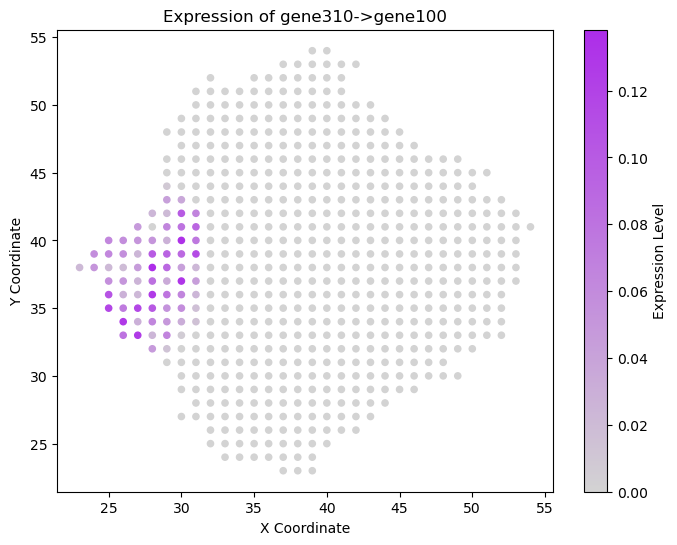

In [ ]:
gene = 'gene310->gene100'
gene_expression = LRI_score[gene]

coord_cell_type = cell_loc.copy()
coord_cell_type['cell_type'] = cell_clus['celltype']
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['x'], merged_data['y'], c=merged_data['expression'], cmap=cmap_custom, s=20)

plt.colorbar(sc, label='Expression Level')
plt.title(f'Expression of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

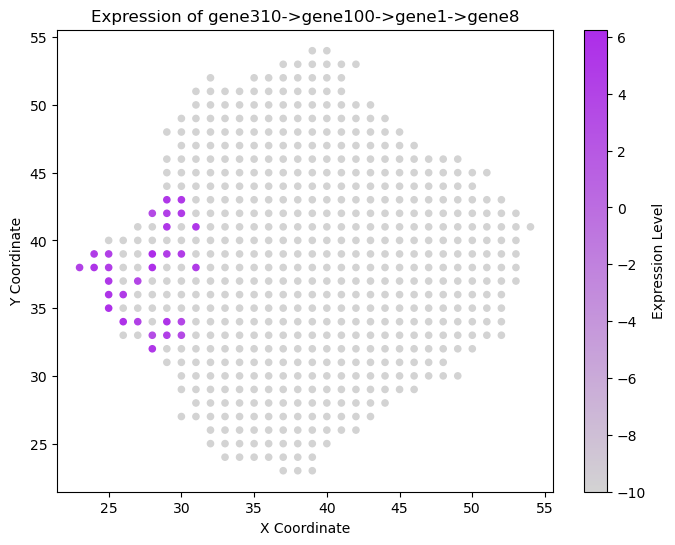

In [13]:
gene = 'gene310->gene100->gene1->gene8'
data = ccc[gene]
gene_expression = np.log10(data*10**9+ 1e-10)

coord_cell_type = cell_loc.copy()
coord_cell_type['cell_type'] = cell_clus['celltype']
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['x'], merged_data['y'], c=merged_data['expression'], cmap=cmap_custom, s=20)

plt.colorbar(sc, label='Expression Level')
plt.title(f'Expression of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Plot the communication direction only for the significant spots for focused pair/path

In [19]:
from Plot import Visualization

In [21]:
Nei_adj = pd.read_csv(base_path + 'CCC/Nei_adj.csv', sep='\t', index_col=None, header=None)

In [22]:
color_map = {
    'celltype1': '#1f77b4',       
    'celltype2': '#ff7f0e', 
    'celltype3': '#2ca02c', 
    'celltype4': '#d62728',   
    'celltype5': '#9467bd'   
}

coord_df = cell_loc.copy()
coord_df['color'] = cell_clus['celltype'].map(color_map)

In [23]:
adj = Visualization.get_sender_adj(Nei_adj, cell_clus)
Sig_path = pd.read_csv(base_path + 'CCC/Significant_paths.csv') 
pathway_name = 'gene310->gene100->gene1->gene8'
res_all_df = Visualization.get_Sig_all_vectors_mlpath(pathway_name, Sig_path, cell_clus, cell_loc , adj)
res_weighted_df = Visualization.get_Sig_weighted_one_vector_mlpath(res_all_df) 
res_weighted_df

,Sample_Name,Comm_Score,Z_Score,Sender,Sender_x,Sender_y,Receiver_x,Receiver_y
0,cell12,0.000331,2.146391,4,25,37,24.771104,36.114363
1,cell12,0.000351,2.146391,6,25,36,24.770980,36.144744
2,cell12,0.000307,2.146391,10,26,37,24.794095,36.203321
3,cell12,0.000328,2.146391,13,25,35,25.571921,35.101247
4,cell12,0.000376,2.146391,16,27,37,26.788671,37.284934
...,...,...,...,...,...,...,...,...
73,cell65,0.000171,5.440364,74,32,40,31.000000,41.000000
74,cell65,0.000171,5.440364,81,32,41,31.000000,41.000000
75,cell65,0.000171,5.440364,83,32,42,31.000000,41.000000
76,cell67,0.000133,4.231200,88,31,44,30.000000,43.000000


In [24]:
Strength_lst = ccc[pathway_name]
# Strength_lst = np.log10(Strength_lst*10**9 + 1e-10)
Strength_df = cell_loc.copy()
Strength_df['Comm_Score'] = Strength_lst

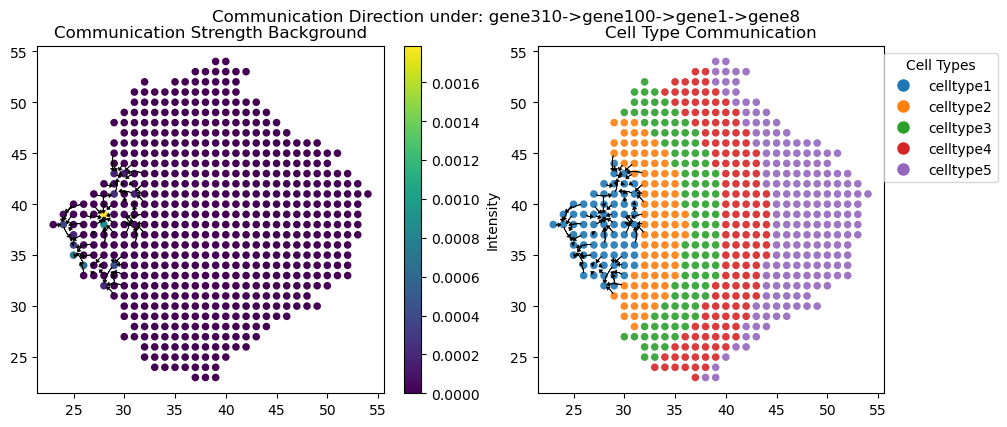

In [26]:
Visualization.plot_communication_double_panel(
    strength_df=Strength_df,
    coord_df=coord_df,
    res_weighted_df=res_weighted_df,
    color_map=color_map,
    pathway_name=pathway_name,
    figpath=None,
    strength_scale=1,
    point_size=30,
    figsize=(10, 4)
)